In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###import

In [ ]:
import numpy as np
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings

In [ ]:
WORKERS = 2
CHANNEL = 3

warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000

#load pic

##Extract zip file

In [ ]:
!pip install pyunpack

In [ ]:
!pip install patool
import patoolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
data_dir = "/content/drive/MyDrive/Dataset/EYEPACS/train.zip.001"

In [ ]:
from pyunpack import Archive
from pyunpack import PatoolError

try:
    Archive(data_dir).extractall("/content/drive/MyDrive/Dataset/EYEPACS")
except PatoolError as e:
    # Handle the exception, print an error message, or log it
    print(f"Error during extraction: {e}")

In [ ]:
from pyunpack import Archive
from pyunpack import PatoolError

try:
    Archive("/content/drive/MyDrive/Dataset/EYEPACS/train.zip.001").extractall("/content/drive/MyDrive/Dataset/EYEPACS")
    Archive("/content/drive/MyDrive/Dataset/EYEPACS/train.zip.002").extractall("/content/drive/MyDrive/Dataset/EYEPACS")
    Archive("/content/drive/MyDrive/Dataset/EYEPACS/train.zip.003").extractall("/content/drive/MyDrive/Dataset/EYEPACS")
    Archive("/content/drive/MyDrive/Dataset/EYEPACS/train.zip.004").extractall("/content/drive/MyDrive/Dataset/EYEPACS")
    Archive("/content/drive/MyDrive/Dataset/EYEPACS/train.zip.005").extractall("/content/drive/MyDrive/Dataset/EYEPACS")


except PatoolError as e:
    # Handle the exception, print an error message, or log it
    print(f"Error during extraction: {e}")

In [ ]:
import subprocess
from pyunpack import Archive

# Concatenate split files (example for Unix-like systems)
subprocess.run(["cat", "/content/drive/MyDrive/Dataset/EYEPACS/train.zip.*", ">", "/content/drive/MyDrive/Dataset/EYEPACS/combined_train.zip"], shell=True)

# Extract the combined file
# Archive("/content/drive/MyDrive/Dataset/EYEPACS/combined_train.zip").extractall("/content/drive/MyDrive/Dataset/EYEPACS")


CompletedProcess(args=['cat', '/content/drive/MyDrive/Dataset/EYEPACS/train.zip.*', '>', '/content/drive/MyDrive/Dataset/EYEPACS/combined_train.zip'], returncode=0)

##Extract 7z file

In [ ]:
!pip install pyunpack

In [ ]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.2 MB/s eta 0:00:00


In [ ]:
data_dir = "/content/drive/MyDrive/Dataset/EYEPACS/diabetic-retinopathy-detection.7z"

In [ ]:
from pyunpack import Archive

Archive(data_dir).extractall("/content/drive/MyDrive/Dataset/EYEPACS")

PatoolError: ignored

## load to drive

In [ ]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os
g_login = GoogleAuth()
g_login.LocalWebserverAuth()
drive = GoogleDrive(g_login)

Failed to start a local web server. Please check your firewall
settings and locally running programs that may be blocking or
using configured ports. Default ports are 8080 and 8090.


AuthenticationError: ignored

#explore data

In [ ]:
# load data
train_label_dir = "/content/drive/MyDrive/DR-Grading2/Dataset/EYEPACS/trainLabels.csv"

In [ ]:
train_label_dir = "/content/drive/MyDrive/DR-Grading2/Dataset/EYEPACS/trainLabels.csv"
df_train = pd.read_csv(train_label_dir)
x = df_train['image']
y = df_train['level']

In [ ]:
x, y = shuffle(x, y, random_state=SEED)

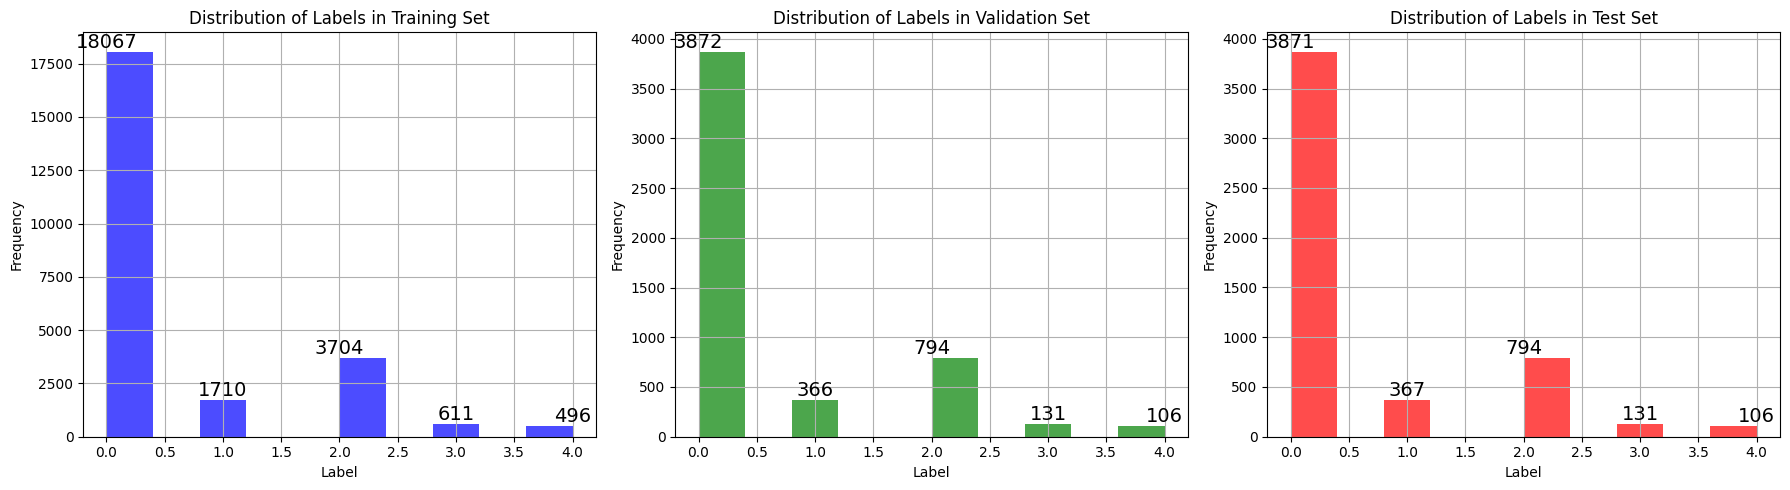

In [ ]:


# Split into train, validation, and test sets
train_x, temp_x, train_y, temp_y = train_test_split(x, y, test_size=0.3,
                                                    stratify=y, random_state=SEED)
valid_x, test_x, valid_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5,
                                                    stratify=temp_y, random_state=SEED)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
train_y.hist(color='blue', alpha=0.7)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')

train_y_counts = train_y.value_counts().sort_index()
for i, count in enumerate(train_y_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=14)

plt.subplot(1, 3, 2)
valid_y.hist(color='green', alpha=0.7)
plt.title('Distribution of Labels in Validation Set')
plt.xlabel('Label')
plt.ylabel('Frequency')

valid_y_counts = valid_y.value_counts().sort_index()
for i, count in enumerate(valid_y_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=14)

plt.subplot(1, 3, 3)
test_y.hist(color='red', alpha=0.7)
plt.title('Distribution of Labels in Test Set')
plt.xlabel('Label')
plt.ylabel('Frequency')

test_y_counts = test_y.value_counts().sort_index()
for i, count in enumerate(test_y_counts ):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=14)

plt.tight_layout()

# Save the plot as an image
plt.savefig('label_distribution_train_valid_test2.png', bbox_inches='tight')

plt.show()


In [ ]:
train_y.value_counts()

NameError: name 'train_y' is not defined

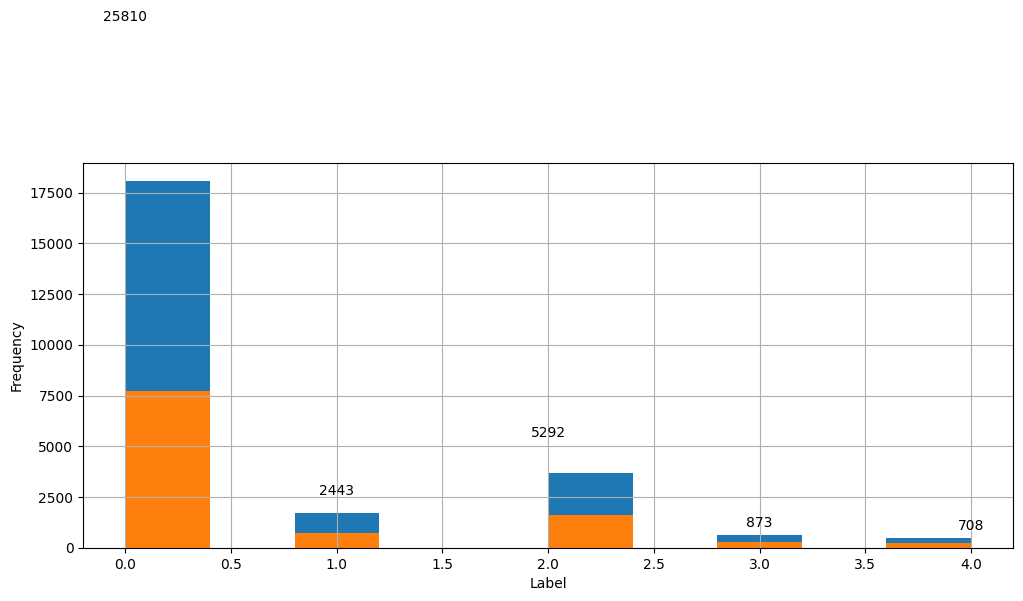

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.3,
                                                      stratify=y, random_state=SEED)

plt.figure(figsize=(12, 5))
# print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()
plt.xlabel('Label')
plt.ylabel('Frequency')

y_counts = y.value_counts().sort_index()
for i, count in enumerate(y_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.savefig('label_distribution.png', bbox_inches='tight')

plt.show()


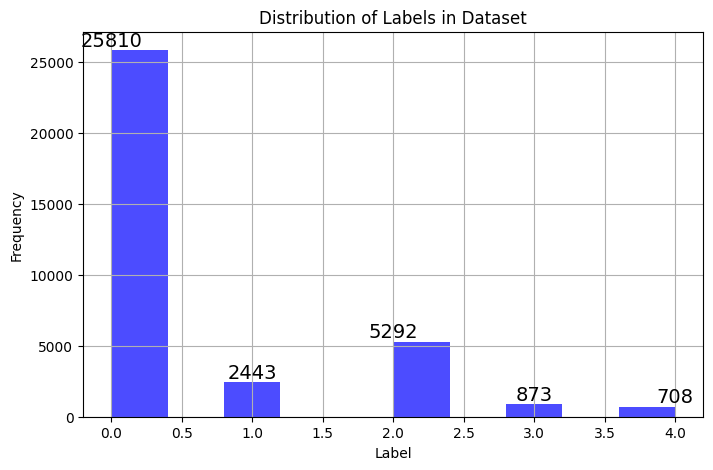

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.3,
                                                      stratify=y, random_state=SEED)

plt.figure(figsize=(8, 5))

y.hist(color='blue', alpha=0.7)
plt.title('Distribution of Labels in Dataset')
plt.xlabel('Label')
plt.ylabel('Frequency')

y_counts = y.value_counts().sort_index()
for label, count in y_counts.items():
    plt.text(label, count, str(count), ha='center', va='bottom', fontsize=14)

plt.savefig('/content/drive/MyDrive/DR-Grading2/graph-plot/label_distribution.png', bbox_inches='tight')

plt.show()


###show image

In [ ]:
path=f"/content/drive/MyDrive/Dataset/EYEPACS/train_10_simple/13_left.jpeg"

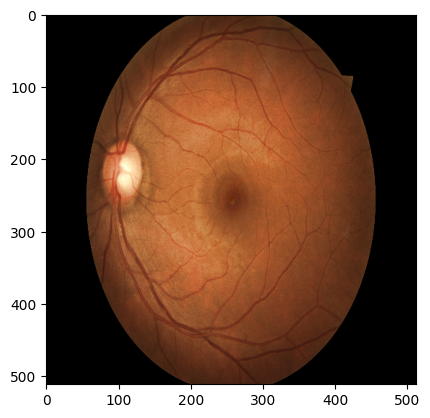

In [ ]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

plt.imshow(image)

### gray map

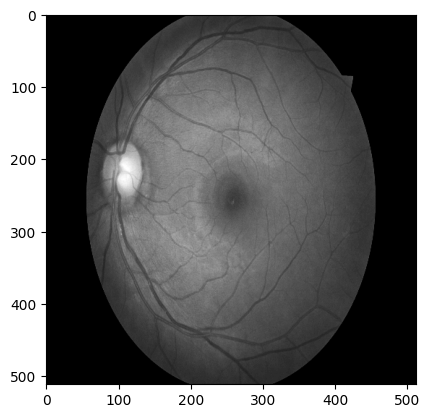

In [ ]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

plt.imshow(image, cmap='gray')

### moderate ? severe ? and PDR

1944 2592
2592 3888


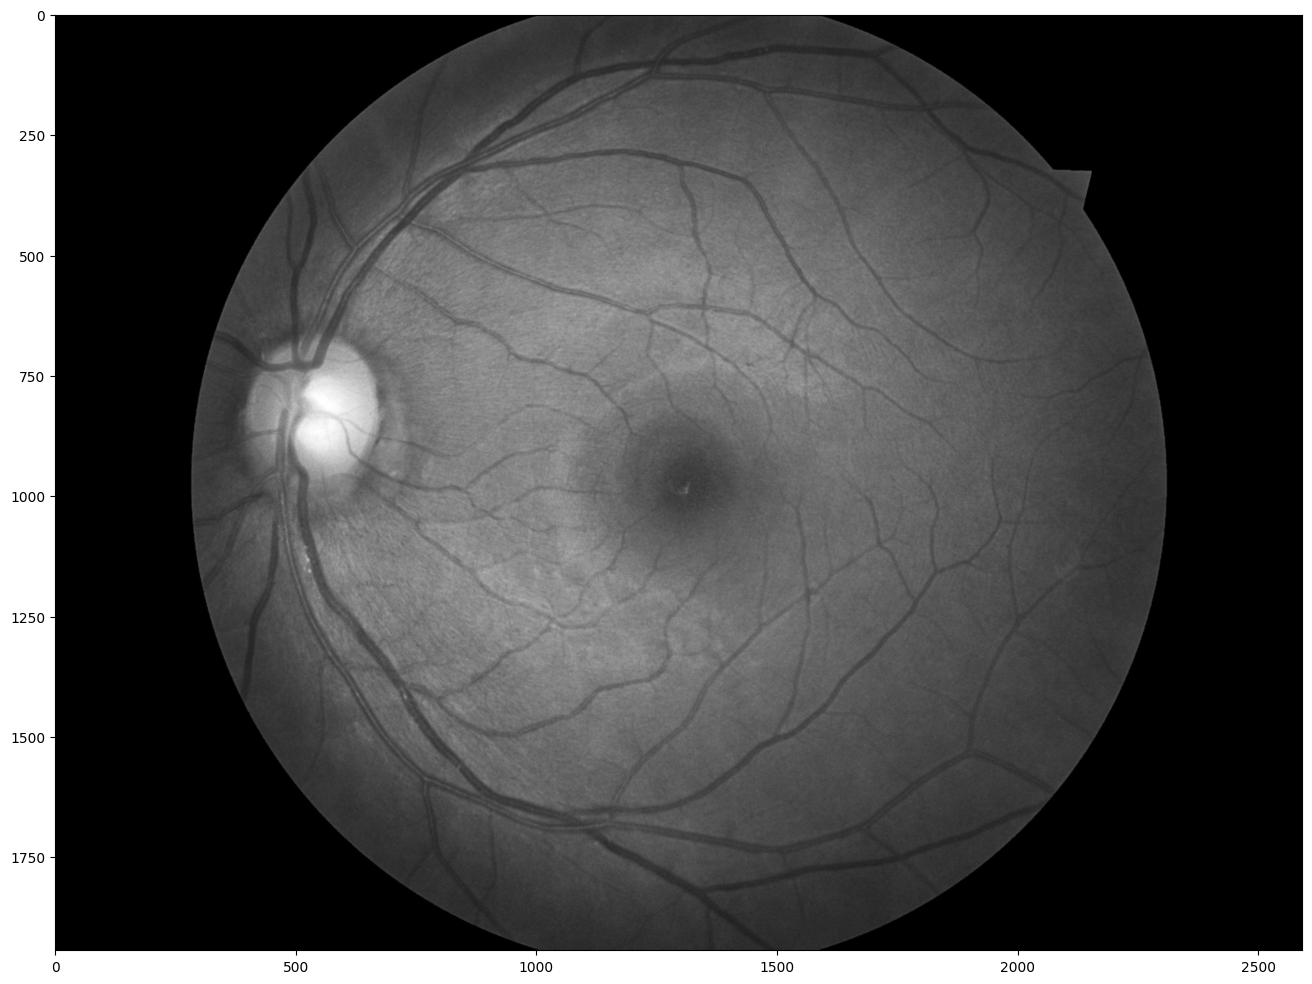

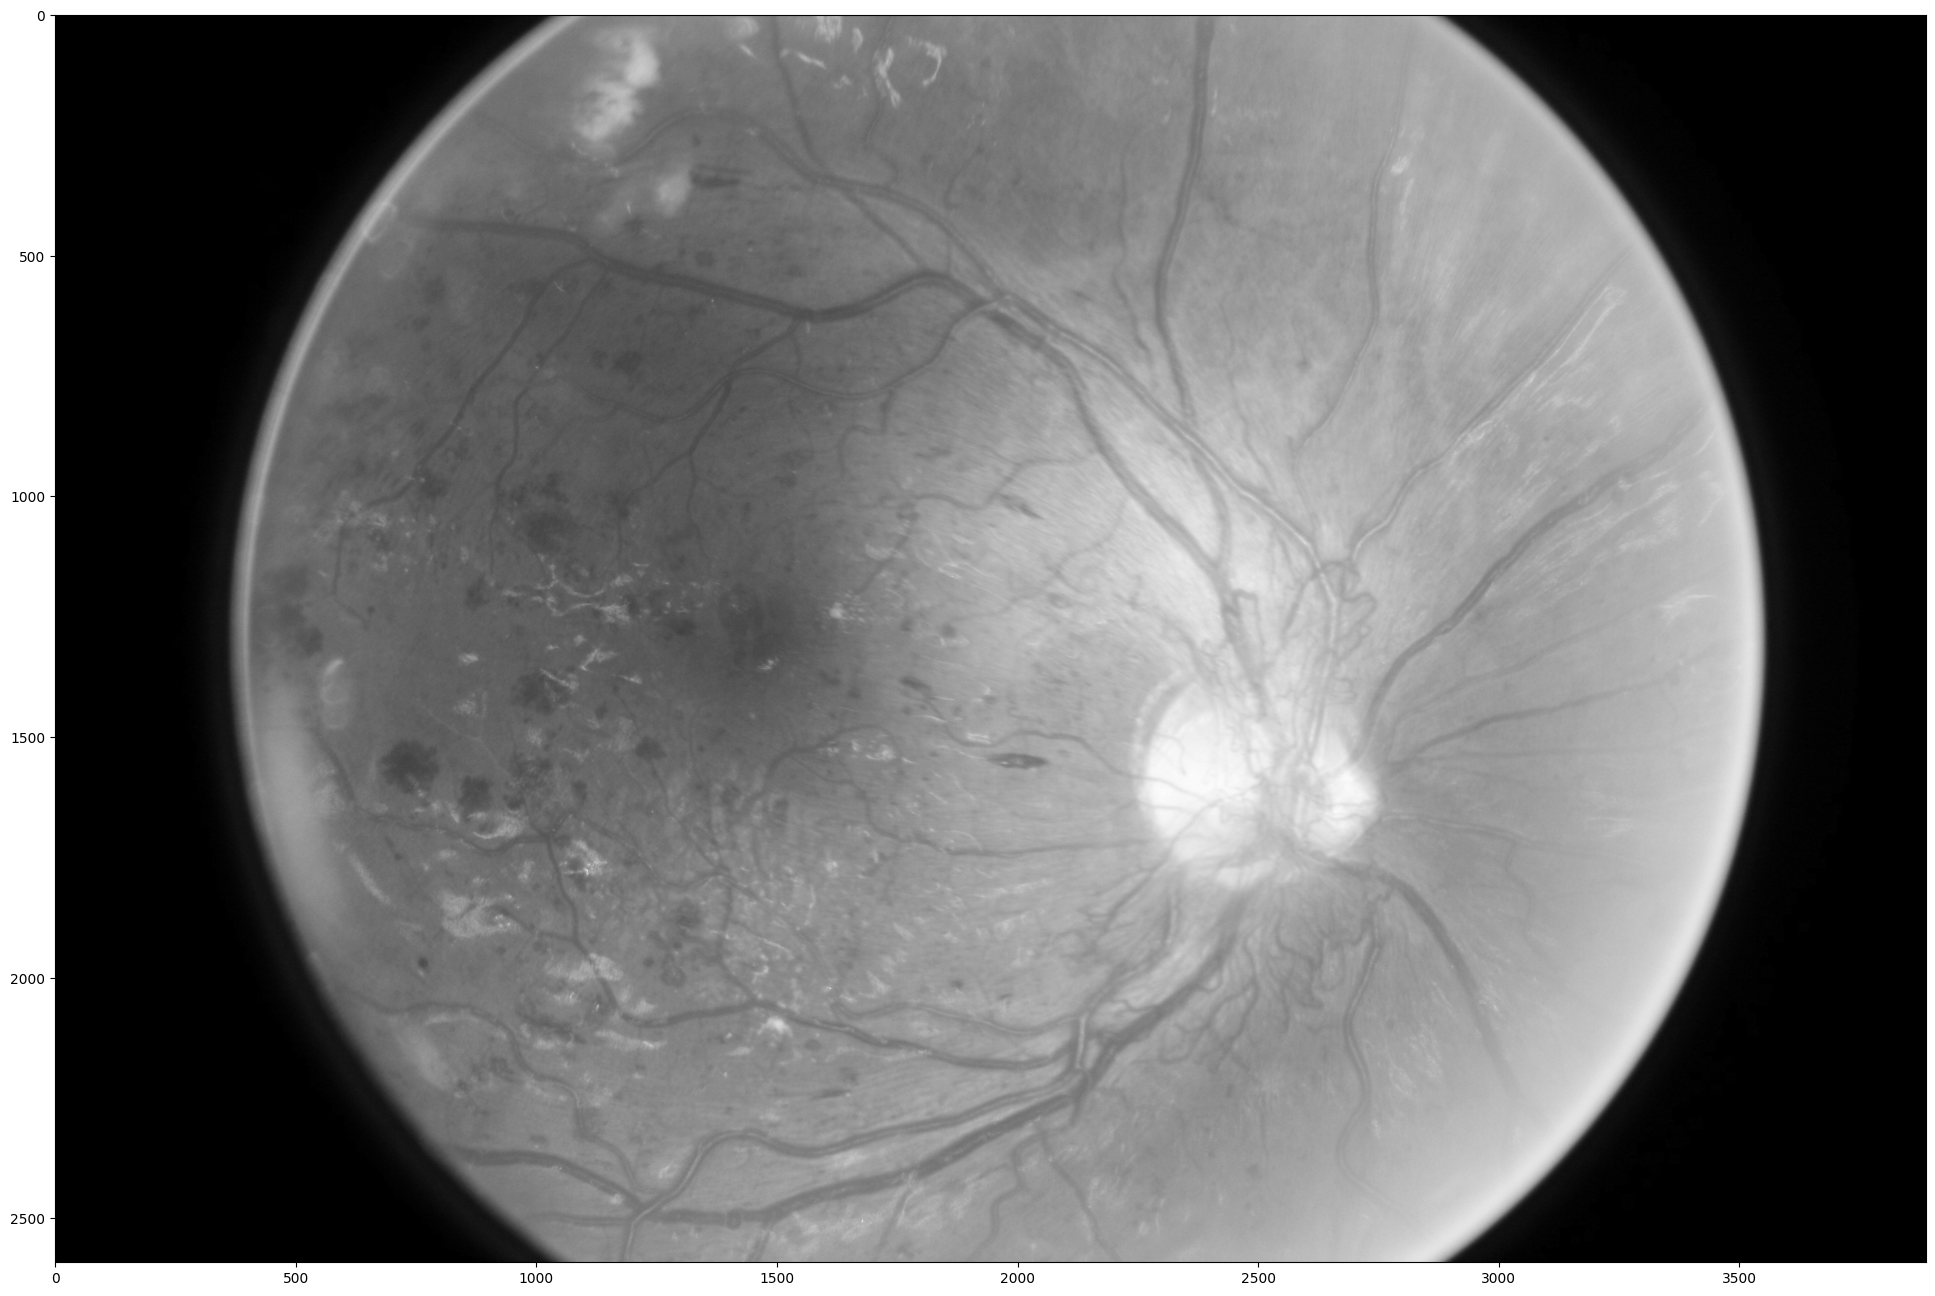

In [ ]:
dpi = 80 #inch

path=f"/content/drive/MyDrive/Dataset/EYEPACS/train_10_simple/13_left.jpeg"
path2=f"/content/drive/MyDrive/Dataset/EYEPACS/train_10_simple/16_left.jpeg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape
print(height, width)
SCALE=2
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE
fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

image = cv2.imread(path2)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = image.shape
print(height, width)
SCALE=2
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE
fig = plt.figure(figsize=figsize)
plt.imshow(image, cmap='gray')

## Try Ben Graham's preprocessing method

In the last competition, Ben Graham (last competition's winner) share insightful way to improve lighting condition. Here, we apply his idea, and can see many important details in the eyes much better. For full details, please refer to his technical report in the link above.
https://github.com/facebookresearch/SparseConvNet.git

### auto crop

In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance

    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

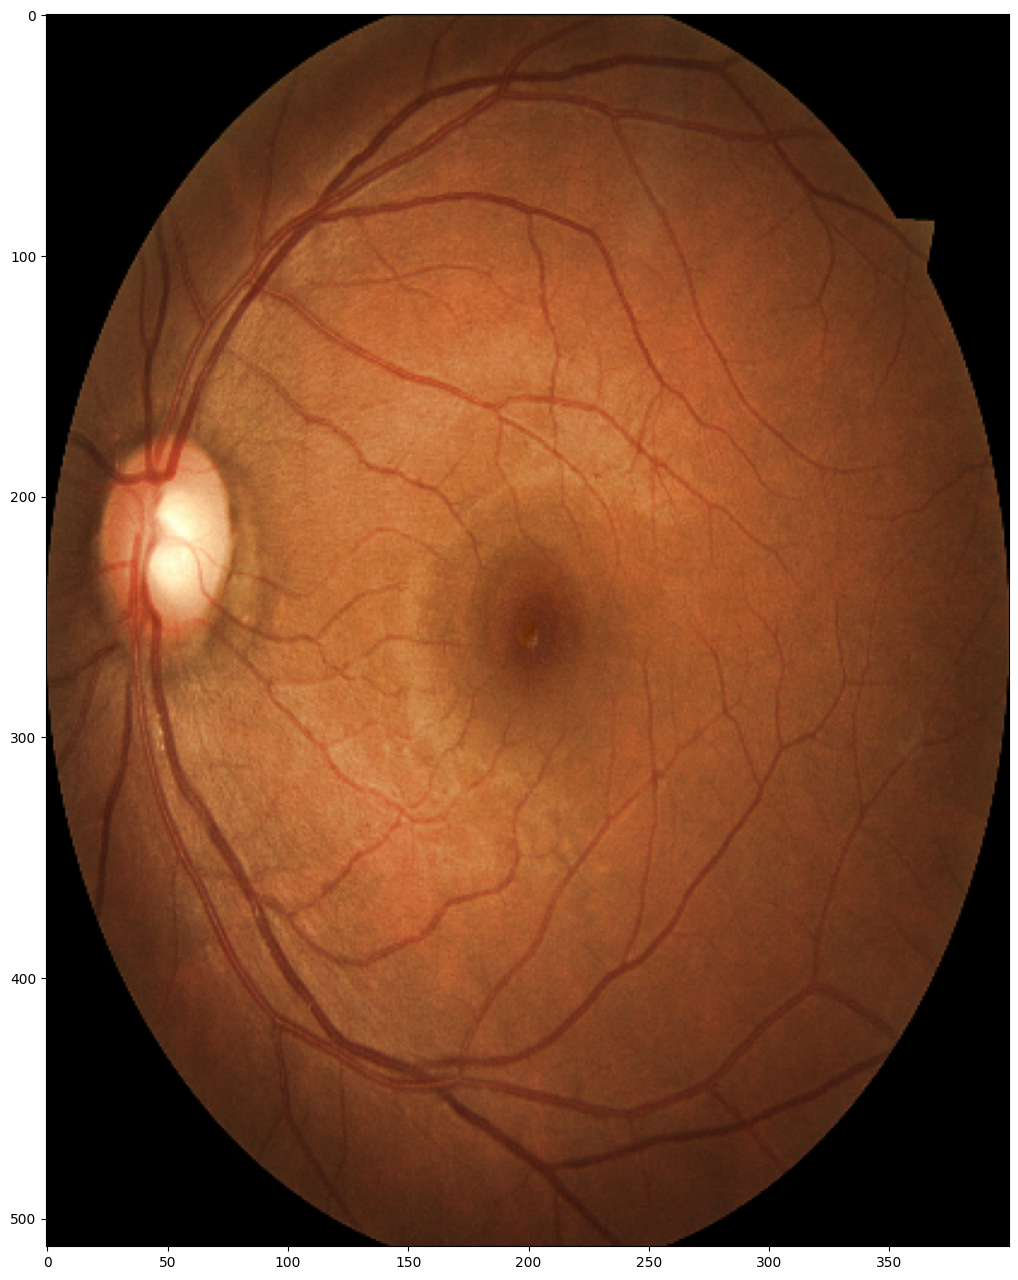

In [ ]:
fig = plt.figure(figsize=(25, 16))
cropped_img = crop_image_from_gray(image)
plt.imshow(cropped_img)

In [ ]:
fig = plt.figure(figsize=(25, 16))
cropped_img = crop_image1(image)
plt.imshow(cropped_img)

ValueError: Cross index must be 1 dimensional

<Figure size 2500x1600 with 0 Axes>

### try circle crop


In [ ]:
def circle_crop(img, sigmaX=10):
    """
    Create circular crop around image centre
    """

    img = cv2.imread(img)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

In [ ]:
NUM_SAMP=5
fig = plt.figure(figsize=(25, 16))
# ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
path=f"../input/aptos2019-blindness-detection/train_images/{row['image']}.png"
image = circle_crop(path,sigmaX=30)

plt.imshow(image)
ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )

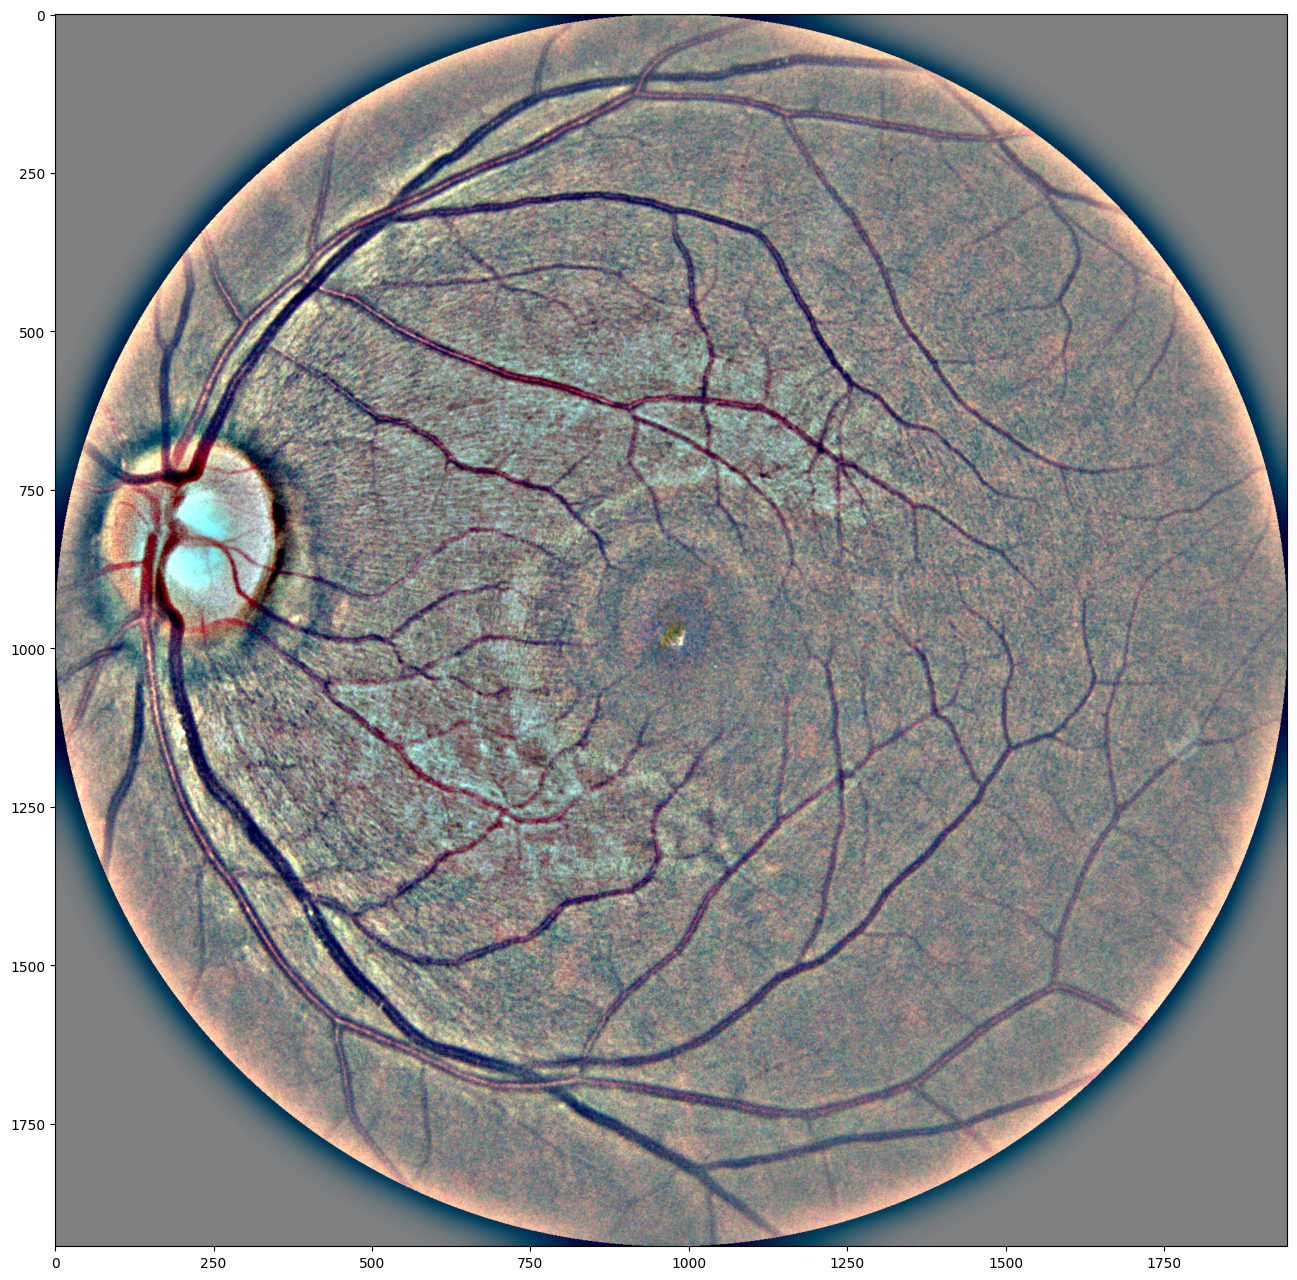

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
# for class_id in sorted(train_y.unique()):
#     for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
# ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
path=f"/content/drive/MyDrive/Dataset/EYEPACS/train_10_simple/13_left.jpeg"
image = circle_crop(path,sigmaX=30)

plt.imshow(image)
# ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

#get all file and do circle crop

In [ ]:
test_csv = "/content/drive/MyDrive/Dataset/EYEPACS/sampleSubmission.csv"

In [ ]:
df_test = pd.read_csv(test_csv)
test_path = df_test['image']


In [ ]:
test_path.head()

0     1_left
1    1_right
2     2_left
3    2_right
4     3_left
Name: image, dtype: object

In [ ]:
NUM_SAMP=5  # Number of samples to display for each class

fig = plt.figure(figsize=(25, 16))
for class_id in sorted(test_path.unique()):
    for i, (idx, row) in enumerate(df_test.loc[df_test['level'] == class_id].head(10).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/MyDrive/Dataset/EYEPACS/test/{row['image']}.png"
        print(path)
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        # ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )

<Figure size 2500x1600 with 0 Axes>